# Tenor saxophone

* Sample duration = 5s
* model = ANN
* target = TENOR

Distinguish between samples with tenor saxophone from those without tenor saxophone. Other brass and (most) woodwind instruments excluded.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.metrics import AUC, Recall
from keras.losses import Hinge

from pickles_to_pandas import pickles_to_pandas

In [3]:
NUM_LABEL_COLS = 13
NUM_COMPONENTS = 30

In [4]:
df = pickles_to_pandas('./data/5s/labeled/features_r02')

In [5]:
df_filtered = df[df['excl'] == '0']  # exclude records we want to exclude
df_filtered.shape

(5411, 10790)

In [6]:
# exclude records we want to exclude
df_filtered = df_filtered[df_filtered['alto'] == '0']  
df_filtered = df_filtered[df_filtered['sop'] == '0']
df_filtered = df_filtered[df_filtered['bari'] == '0']
df_filtered = df_filtered[df_filtered['clrt'] == '0']
df_filtered = df_filtered[df_filtered['tora'] == '0']
df_filtered = df_filtered[df_filtered['othr'] == '0']
df_filtered = df_filtered[df_filtered['trmp'] == '0']
df_filtered = df_filtered[df_filtered['trmb'] == '0']
df_filtered = df_filtered[df_filtered['otrb'] == '0']

num_x_cols = df_filtered.shape[1] - NUM_LABEL_COLS - 1  
# last bit to adjust for zero indexing
data = df_filtered.iloc[:, 1:num_x_cols].to_numpy() 
# ^ these are the features
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

target = df_filtered[['tenr']].to_numpy().ravel()  
# ^ these are the labels

print(data.shape)
print(target.shape)

(3483, 10775)
(3483,)


### Use PCA to reduce number of features

In [7]:
pca = PCA(n_components=NUM_COMPONENTS)
pca.fit(data)
d = pca.transform(data)

### Generate train, test and validation sets

In [8]:
x_train, x_test, y_train, y_test = \
     train_test_split(d, target, test_size=0.2, random_state=0)
print(y_train.shape)
print(y_test.shape)
split_index = y_test.shape[0] // 2
print(split_index)
x_validate = x_test[0:split_index]
y_validate = y_test[0:split_index]
x_test = x_test[split_index:]
y_test = y_test[split_index:]
print(x_train.shape)
print(x_validate.shape)
print(x_test.shape)

(2786,)
(697,)
348
(2786, 30)
(348, 30)
(349, 30)


### Define ANN model

In [9]:
model = Sequential()
model.add(Dense(64, activation='relu'))
# https://keras.io/api/layers/regularization_layers/dropout/
model.add(Dropout(0.1))  #  input_shape=(2,)
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [10]:
# See: https://keras.io/api/metrics/classification_metrics
# AUC(name='auc'), 
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall')])

### Train

In [11]:
history = model.fit(x_train, y_train, epochs=50, batch_size=10, 
                    validation_data=(x_validate, y_validate))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 2786 samples, validate on 348 samples
Epoch 1/50
2786/2786 [==============================] - 1s 332us/step - loss: 0.8395 - recall: 0.4674 - val_loss: 0.4438 - val_recall: 0.7301
Epoch 2/50
2786/2786 [==============================] - 1s 190us/step - loss: 0.4809 - recall: 0.7202 - val_loss: 0.3685 - val_recall: 0.7975
Epoch 3/50
2786/2786 [==============================] - 1s 191us/step - loss: 0.3987 - recall: 0.7758 - val_loss: 0.3431 - val_recall: 0.7853
Epoch 4/50
2786/2786 [==============================] - 1s 187us/step - loss: 0.3604 - recall: 0.7965 - val_loss: 0.3333 - val_recall: 0.8160
Epoch 5/50
2786/2786 [==============================] - 1s 189us/step - loss: 0.3351 - recall: 0.8124 - val_loss: 0.3210 - val_recall: 0.8098
Epoch 6/50
2786/2786 [==============================] - 1s 188us/step - loss: 0.3128 - recall: 0.8323 - val_loss: 0.2979 - val_recall: 0.8160
Epoch 

In [12]:
# auc, 
loss, recall = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))

349/349 [==============================] - 0s 52us/step
Recall: 84.25


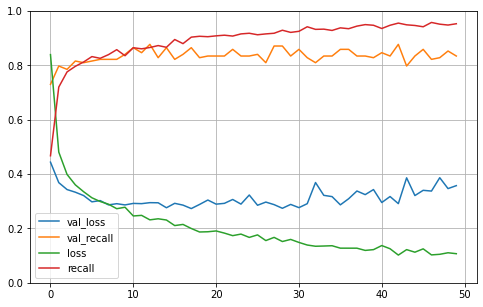

In [13]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


In [14]:
# See: https://keras.io/api/metrics/classification_metrics
# AUC(name='auc'), 
model.compile(loss='hinge', optimizer='adam', 
              metrics=[Recall(name='recall')])

In [15]:
history = model.fit(x_train, y_train, epochs=50, batch_size=10, 
                    validation_data=(x_validate, y_validate))

Train on 2786 samples, validate on 348 samples
Epoch 1/50
2786/2786 [==============================] - 1s 295us/step - loss: 0.6051 - recall: 0.9515 - val_loss: 0.6558 - val_recall: 0.8282
Epoch 2/50
2786/2786 [==============================] - 1s 190us/step - loss: 0.6043 - recall: 0.9467 - val_loss: 0.6572 - val_recall: 0.8221
Epoch 3/50
2786/2786 [==============================] - 1s 192us/step - loss: 0.6030 - recall: 0.9380 - val_loss: 0.6419 - val_recall: 0.8712
Epoch 4/50
2786/2786 [==============================] - 1s 189us/step - loss: 0.6026 - recall: 0.9475 - val_loss: 0.6487 - val_recall: 0.8528
Epoch 5/50
2786/2786 [==============================] - 1s 192us/step - loss: 0.6013 - recall: 0.9459 - val_loss: 0.6469 - val_recall: 0.8650
Epoch 6/50
2786/2786 [==============================] - 1s 199us/step - loss: 0.5959 - recall: 0.9515 - val_loss: 0.6403 - val_recall: 0.8650
Epoch 7/50
2786/2786 [==============================] - 1s 190us/step - loss: 0.5972 - recall: 0.9507

In [16]:
# auc, 
loss, recall = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))

349/349 [==============================] - 0s 57us/step
Recall: 87.67


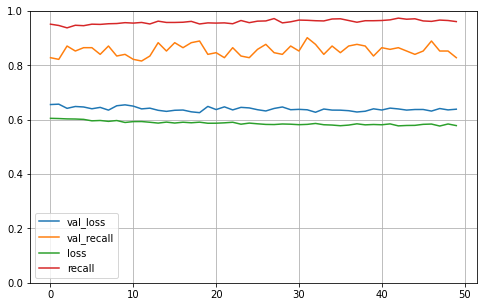

In [17]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


### Discussion of above

This point represents a fair amount of tinkering. Guessing at network structures (numbers of neurons, numbers of layers, etc). Added dropout layer in attempt to prevent overfitting. Validation loss still creeping up (not good). Larger networks with more layers did not seem to work as well. Tried all Keras optimizers (SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam). Tried the following loss functions: binary_crossentropy, hinge, squared_hinge, and categorical_hinge. Only the first two seemed at all promising. Binary cross-entropy had the recall-loss curve that made the most sense. Hinge gave a slightly better result, but the result seems odd -- curves are flat and loss is high. I don't know that I trust this model.

